# Imports

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import math
import time
import subprocess
import os
from IPython.display import clear_output
from matplotlib import cm
CMAP = cm.summer
from numpy import random
from scipy.interpolate import interp1d

from analysis import *
from sim_funcs import *
from consts import *



import matplotlib
import matplotlib.pyplot as plt


matplotlib.rc("xtick", labelsize=27)
matplotlib.rc("ytick", labelsize=27)
matplotlib.rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
matplotlib.rc("text", usetex=True)


# Calculating Critical Mass

In [2]:
#### comment out bc not running this, only loading in flux_data.npy that Matt created

'''
sims = np.sort(get_all_sim_dirs(data_folder = "data_1000_m6/"))
total_flux = np.zeros(80)
for sim in sims:
    v,flux,flux_er = get_cube_avg_flux(sim)
    total_flux += flux

mean_flux = total_flux/1000
data = np.array([v,mean_flux])
np.save("flux_data.npy",data)
'''

'\nsims = np.sort(get_all_sim_dirs(data_folder = "data_1000_m6/"))\ntotal_flux = np.zeros(80)\nfor sim in sims:\n    v,flux,flux_er = get_cube_avg_flux(sim)\n    total_flux += flux\n\nmean_flux = total_flux/1000\ndata = np.array([v,mean_flux])\nnp.save("flux_data.npy",data)\n'

In [3]:
v,mean_flux = np.load("flux_data.npy")

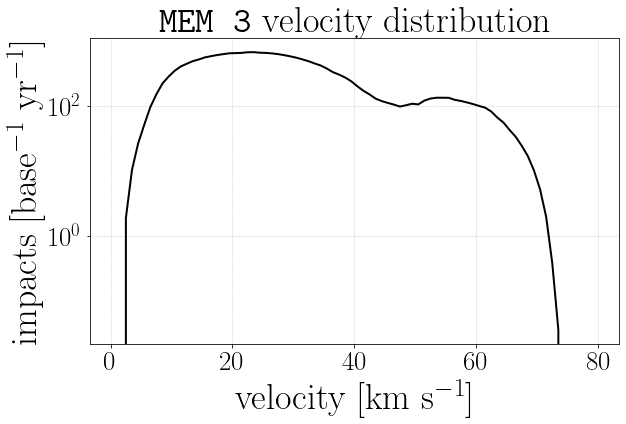

In [4]:
plt.figure(figsize=[9,6])
plt.plot(v, mean_flux, color="k", linewidth=2)

plt.yscale("log")

plt.xlabel(r"velocity [km s$^{-1}$]", fontsize=36)
plt.ylabel(r"impacts [base$^{-1}$ yr$^{-1}$]", fontsize=36)

plt.title(r"\texttt{MEM~3} velocity distribution", fontsize=36)

plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

plt.tick_params(axis='both', which='major', labelsize=27)
plt.tight_layout()

plt.savefig("figures/vel_dist.pdf", bbox_inches="tight")


In [5]:
# Start the timer
np.random.seed(9)

start_time = time.time()


mfcdf = np.cumsum(mean_flux)
vel_cdf = (mfcdf-np.min(mfcdf))/(np.max(mfcdf)-np.min(mfcdf)) 
interp_vel = interp1d(vel_cdf, v)
N_samples = int(1.0e7)
x = random.rand(N_samples)
vel = interp_vel(x)

t_w = 0.48
rho_b = 2.851
sigma = 52
S = 11.43
F_2 = 1
rho_p = 8.9
theta = 0
num = t_w**2 * S * sigma/70
denom = np.power(rho_b,1.0/3.0)*np.power(vel*np.cos(theta),2.0)
m_c = (np.pi/6.0)*3.918**3*F_2**3 *num/denom

# End the timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")



Elapsed time: 0.6825 seconds


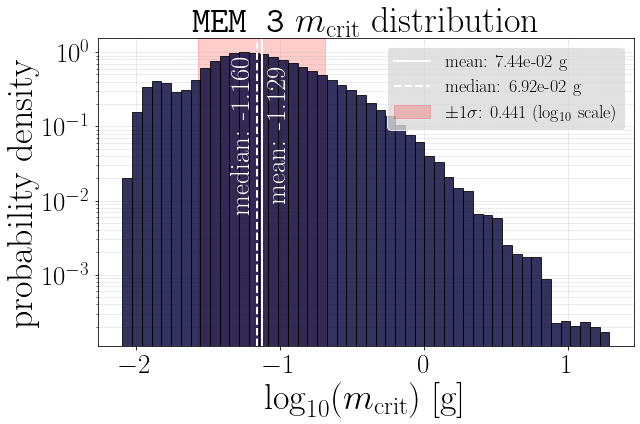

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Compute stats in log10 space
lmc = np.log10(m_c)
mean_val = np.mean(lmc)
std_val = np.std(lmc)
med_val = np.median(lmc)

# Convert stats back to linear (grams) for legend display
mean_lin = 10**mean_val
med_lin = 10**med_val

# Create figure
plt.figure(figsize=(9, 6))

# Histogram in log10 space
plt.hist(lmc, bins=50, log=True, density=True,
         color="#000035", edgecolor='k', alpha=0.8, zorder=2)

# Plot mean and median lines (in log10 scale)
plt.axvline(mean_val, color='w', linestyle='-', linewidth=2, label=f'mean: {mean_lin:.2e} g')
plt.axvline(med_val, color='w', linestyle='--', linewidth=2, label=f'median: {med_lin:.2e} g')

# Shaded ±1σ in log space (for visual, label uses linear std)
plt.axvspan(mean_val - std_val, mean_val + std_val,
            color='red', alpha=0.2, label=rf'$\pm1\sigma$: {std_val:.3f} (log$_{{10}}$ scale)')

# Add text annotations with adjusted alignment
ymin, ymax = plt.ylim()
text_y_pos = ymax * 0.05  # base reference height

# Mean: align text so the top of the words touches the line
plt.text(mean_val+.03, text_y_pos, f'mean: {mean_val:.3f}',
         color='w', fontsize=27, rotation=90,
         va='center', ha='left')   # top aligned

# Median: align text so the bottom of the words touches the line
plt.text(med_val-.02, text_y_pos, f'median: {med_val:.3f}',
         color='w', fontsize=27, rotation=90,
         va='center', ha='right')  # bottom aligned

# Axis labels
plt.xlabel(r"$\log_{10}(m_{\rm crit}$) [g]", fontsize=36)
plt.ylabel("probability density", fontsize=36)

# Legend with linear-space mass values
plt.legend(fontsize=18, loc='upper right', frameon=True, facecolor='#dadada', edgecolor='w')

# Grid and ticks
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7, zorder=1)
plt.tick_params(axis='both', which='major', labelsize=27)

plt.title(r'\texttt{MEM~3} $m_{\rm crit}$ distribution', fontsize=36)
# Layout and save
plt.tight_layout()
plt.savefig("figures/m_crit.pdf", bbox_inches="tight")



In [7]:
thetas, phis, flux = read_flux_file("flux_rates_1000_m6.csv")
mean_flux = np.mean(flux)
m_grun = np.logspace(-6,1,100)
grun_flux = grun(m_grun)*BASE_SURF_AREA

scaling_factor = mean_flux/grun_flux[0]
flux = grun_flux*scaling_factor
mass_cdf =(flux-np.min(flux))/(np.max(flux)-np.min(flux))
interp_mass = interp1d(mass_cdf, m_grun)


In [8]:
y = random.rand(N_samples)
m_derived = interp_mass(y)
ratio = np.log10(m_derived/m_c)
fraction = np.size(np.where(ratio<0))/np.size(ratio)
percentage = fraction*100

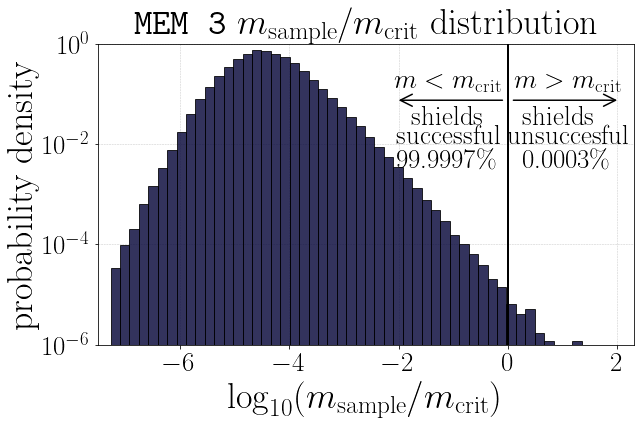

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Create figure
plt.figure(figsize=(9, 6))

# Histogram of ratio (linear x-axis, log y-axis)
plt.hist(ratio, bins=50, density=True,
         color="#000035", edgecolor='k', alpha=0.8, zorder=2)

# Log scale on y-axis only
plt.yscale('log')

# Add vertical line at 0 (Mcrit reference)
plt.axvline(0, color='k', linestyle='-', linewidth=2, zorder=3)

# Axis labels
plt.xlabel(r"$\log_{10}(m_{{\rm sample}}/m_{{\rm crit}})$", fontsize=36)
plt.ylabel("probability density", fontsize=36)

# Add annotations with arrows (black, text above)
text_x = 1.1
ymin, ymax = plt.ylim()
arrow_y = ymax * 0.05   # arrow vertical position
text_y = ymax * 0.07   # text above the arrows
text_y2 = ymax * 0.007
text_y3 = ymax * 0.0018

# Left arrow + text
plt.annotate(
    "",
    xy=(-0.1, arrow_y), xytext=(-2, arrow_y),
    arrowprops=dict(arrowstyle="<-", color='k', lw=1.5, shrinkA=0, shrinkB=0, mutation_scale=30)
)
plt.text(-text_x, text_y, r"$m < m_{\rm crit}$",
         color='k', fontsize=27, ha='center', va='bottom')
plt.text(-text_x, text_y2, r"shields\\successful",
         color='k', fontsize=27, ha='center', va='bottom')
plt.text(-text_x, text_y3, rf"{percentage:.4f}\%",
         color='k', fontsize=27, ha='center', va='bottom')

# Right arrow + text
plt.annotate(
    "",
    xy=(0.1, arrow_y), xytext=(2, arrow_y),
    arrowprops=dict(arrowstyle="<-", color='k', lw=1.5, shrinkA=0, shrinkB=0, mutation_scale=30)
)
plt.text(text_x, text_y, r"$m > m_{\rm crit}$",
         color='k', fontsize=27, ha='center', va='bottom')
plt.text(text_x, text_y2, r"shields\\unsuccesful",
         color='k', fontsize=27, ha='center', va='bottom')
plt.text(text_x, text_y3, rf"{100-percentage:.4f}\%",
         color='k', fontsize=27, ha='center', va='bottom')


plt.xlim(-7.5,2.3)
plt.ylim(1e-6,1e0)

# Grid and ticks
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7, zorder=1)
plt.tick_params(axis='both', which='major', labelsize=27)

# Title
plt.title(r'\texttt{MEM~3} $m_{{\rm sample}}$/$m_{{\rm crit}}$ distribution', fontsize=36)

# Layout and save
plt.tight_layout()
plt.savefig("figures/m_ratio.pdf", bbox_inches="tight")

